In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
a = 2.0
b = -3.0
c = 10.0

d = a * b + c

print(d)

4.0


In [3]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

a += h

d2 = a * b + c

print(d1, d2, (d2-d1)/h)

4.0 3.9999699999999994 -3.000000000064062


In [158]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.label = label
        self._op = _op
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)  - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1  - out.data ** 2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [32]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

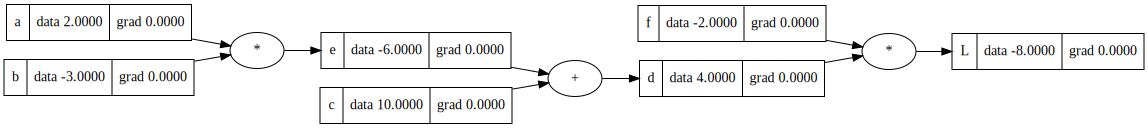

In [34]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

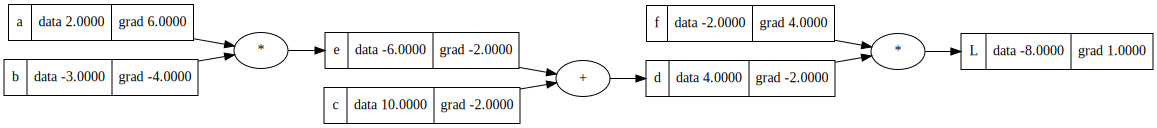

In [44]:
draw_dot(L)

In [43]:
L.grad = 1.0

f.grad = d.data
d.grad = f.data

e.grad = f.data
c.grad = f.data

a.grad = f.data * b.data
b.grad = f.data * a.data

In [ ]:
dL/dL = 1.0

L = f * d
dL/df = d
dL/dd = f

d = e + c
dL / de = dL / dd * dd/de = f * 1.0
dL / dc = dL / dd * dd/dc = f * 1.0

e = a * b
dL / da = dL / dd * dd/de * de/da = f * 1.0 * b
dL / db = dL / dd * dd/de * de/db = f * 1.0 * a

In [45]:
lr = 0.0001

a.data = a.data - lr * a.grad
b.data = b.data - lr * b.grad
c.data = c.data - lr * c.grad
f.data = f.data - lr * f.grad

e = a * b
d = e + c 
L = d * f

print(L)

Value(data=-8.007200639904)


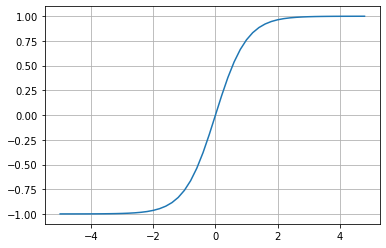

In [47]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [71]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

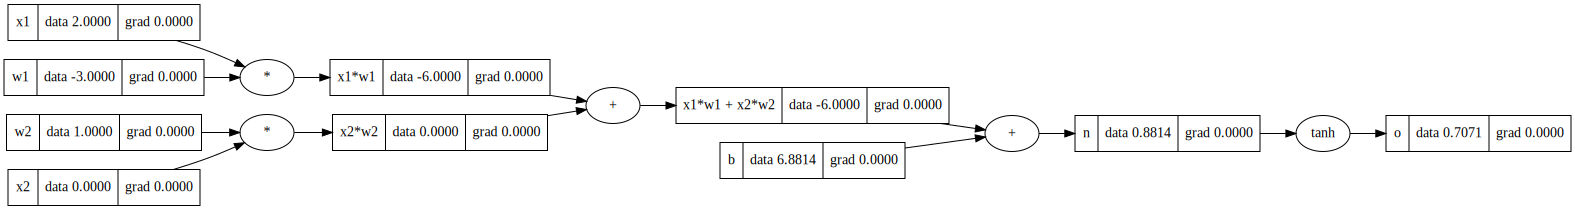

In [72]:
draw_dot(o)

In [73]:
o.backward()

o
n
b
x1*w1 + x2*w2
x1*w1
w1
x1
x2*w2
x2
w2


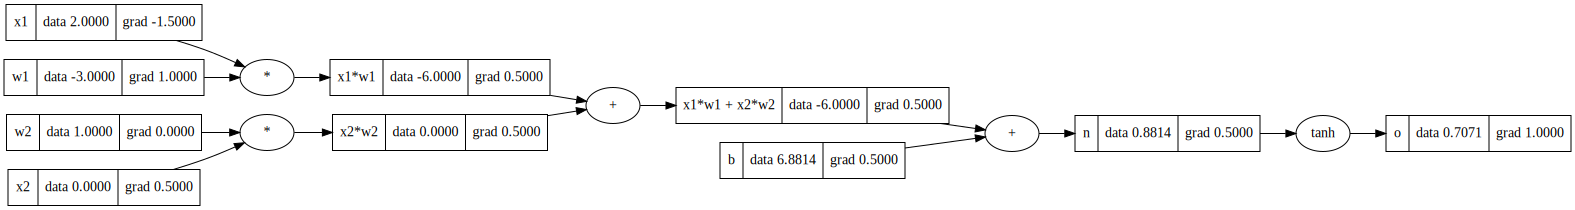

In [74]:
draw_dot(o)

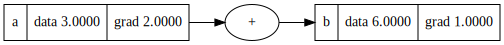

In [80]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)

In [81]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [159]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        res = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        act = res.tanh()
        return act
    
    def parameters(self):
        return self.w + [self.b]

In [160]:
x = [2.0, 3.0]
n = Neuron(2)

n(x)

Value(data=0.14759740747279182)

In [161]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        
        return outs if len(outs) != 1 else outs[0]
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [162]:
x = [2.0, 3.0]
n = Layer(2, 3)

n(x)

[Value(data=-0.9957799942221517),
 Value(data=0.24804515275392888),
 Value(data=0.9851331945004278)]

In [163]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [209]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

n(x)

Value(data=-0.8711474419374461)

In [210]:
# draw_dot(n(x))

In [211]:
len(n.parameters())

41

In [212]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [258]:
ypred = [n(x) for x in xs]

In [269]:
ypred

[Value(data=0.0003541151459055849),
 Value(data=0.00026397752473566956),
 Value(data=-0.00018261057199864654),
 Value(data=-0.0004060639243414943)]

In [260]:
loss = sum((yout-ygt)*(yout-ygt) for ygt, yout in zip(ys, ypred))

In [261]:
print(loss)

Value(data=7.575055175056302)


In [262]:
for p in n.parameters():
    p.grad = 0

In [263]:
loss.backward()

In [264]:
lr = 0.01

for p in n.parameters():
    p.data = p.data - lr * p.grad

In [268]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)*(yout-ygt) for ygt, yout in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    lr = 0.01

    for p in n.parameters():
        p.data = p.data - lr * p.grad
        
    print(k, loss)

0 Value(data=4.008537034228138)
1 Value(data=4.0033652443046535)
2 Value(data=4.001428823730789)
3 Value(data=4.000706262736384)
4 Value(data=4.00043675721651)
5 Value(data=4.000336017265025)
6 Value(data=4.0002980970763895)
7 Value(data=4.000283553740127)
8 Value(data=4.0002777084676975)
9 Value(data=4.000275099279251)
10 Value(data=4.000273693877361)
11 Value(data=4.000272736097143)
12 Value(data=4.000271944590641)
13 Value(data=4.000271214675811)
14 Value(data=4.000270507402826)
15 Value(data=4.000269808278909)
16 Value(data=4.000269111911033)
17 Value(data=4.000268416291922)
18 Value(data=4.000267720674037)
19 Value(data=4.000267024778548)
